## 0. Goal
Run UMAP on the trained VAE latent features <br>
Properly control what goes into the UMAP. Just run a giant UMAP that includes all sliding windows from all syllables.

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle, gc
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_base = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed')
fd_data = os.path.join(fd_base, 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
pairIDs = ['pair5CU29CU55', 'pair4CU68CU53', 'pair4CU68CU53', 'pair2CU20CU25'];
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8.5]]
# what spectroram dataset to use, see ZZp1_makeSpec_traj_v1.ipynb
spec_suffix = 'Spectrogram2'
spec_run = 'spec_goffinet_traj_256_236'
# what vae run to use
vae_run = 'traj_chop_32_1_32'
# shape of the spectrogram window
X_SHAPE = (128, 128)
# width of the sliding window in unit of frames
win_frame = 32
hop_frame = 1

In [5]:
# parameters for UMAP
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}
# where to save UMAP results
umap_suffix = 'UMAPcomp'
umap_run = f'{param_umap["n_components"]}_{param_umap["n_neighbors"]}_{param_umap["min_dist"]}_{param_umap["metric"]}'
print(umap_run)

2_25_0_euclidean


In [6]:
# select birds to run
bi = 0
birdID = birdIDs[bi]
pairID = pairIDs[bi]

In [33]:
# what VAE data to use
fd_vae = os.path.join(fd_data, birdID, 'Traj', 'applySylAll', f'latents.{vae_run}')
fn_info = os.path.join(fd_vae, f'{birdID}.latents.{vae_run}.info.csv')
fn_h5 = os.path.join(fd_vae, f'{birdID}.latents.{vae_run}.h5')
print(f'Read VAE latents data from: {fd_vae}')
info = pd.read_csv(fn_info, index_col=0)
print(info.shape)

Read VAE latents data from: /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySylAll/latents.traj_chop_32_1_32
(92140, 24)


## 2. Prepare inputs for UMAP

In [34]:
### 2.0 All syllables
syl = ['v', 'b', 'h', 'e', 'x']
dur_thre = [0, 0, 0, 0, 0]  # cutoff of duration for each syllable category
batch = ['batch1', 'batch2']

In [35]:
umap_run = '.'.join(syl) + '-all'
# where to save
fd_umap = os.path.join(fd_base, 'Figures', pairID, 'CompoundSyl', birdID, umap_suffix, umap_run)
print(fd_umap)
if not os.path.exists(fd_umap):
    os.makedirs(fd_umap)

/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/CompoundSyl/pair5RigCCU29/UMAPcomp/v.b.h.e.x-all


#### Filter out syllable entries based on criteria

In [36]:
# add a duration column to the info table
fs = 20000
info['duration'] = (info['iend'] - info['istart']) / fs

In [37]:
# correct the 'label' field for batch 2
ibatch2 = info[info['batch']=='batch2'].index
info.loc[ibatch2, 'label'] = [a[0] for a in info.loc[ibatch2, 'label']]

In [38]:
# first check syllable labels and batch belonging
info_p = info[info['label'].isin(syl) & info['batch'].isin(batch)].copy()
print(info_p.shape)

(92140, 25)


In [40]:
# then check syllable duration
idx_inc = OrderedDict()
for si, ss in enumerate(syl):
    temp = info_p[(info_p['label']==ss)  & (info_p['duration']>=dur_thre[si])]
    print(temp.shape)
    idx_inc[ss] = list(temp.index)

(25584, 25)
(5914, 25)
(29429, 25)
(4365, 25)
(26848, 25)


#### Select sliding windows: sample equal syllable renditions, systematic sliding

In [41]:
idx_sample = OrderedDict()
random.seed(1992)
for si, ss in enumerate(syl):
    if num_sample>0:
        act_sample = min([num_sample, len(idx_inc[ss])])
        idx_sample[ss] = random.sample(idx_inc[ss], act_sample)
    else:
        idx_sample[ss] = idx_inc[ss]
    print(f'{ss} sampled {len(idx_sample[ss])} renditions')

v sampled 25584 renditions
b sampled 5914 renditions
h sampled 29429 renditions
e sampled 4365 renditions
x sampled 26848 renditions


In [42]:
# flatten the sampled index list
idx_flat = [item for sublist in idx_sample.values() for item in sublist]
# subset the info dataframe 
info_s = info_p.loc[idx_flat]

In [43]:
# read in all the VAE data, construct meta info at the syllable level
info_umap = []
d_latents = []
count = 0
with h5py.File(fn_h5, "r") as f:
    for ri in tqdm.tqdm(info_s.index):
    # for ri in info_s.index[0:3]:
        syl_ID = info_s.loc[ri, 'syl_ID']
        d = f[syl_ID][:]
        # exclude the extra silent pad
        d_latents.append(d)
        # grab info regarding the syllable
        row = info[info['syl_ID']==syl_ID].copy()
        row.index = range(row.shape[0])
        row.loc[0, 'count_start'] = count
        count = count + d.shape[0]
        row.loc[0, 'count_end'] = count
        info_umap.append(row)

100%|██████████| 92140/92140 [09:25<00:00, 163.03it/s]


In [44]:
# convert to dataframe
info_umap = pd.concat(info_umap, ignore_index=True)
info_umap['count_start'] = info_umap['count_start'].astype('int64')
info_umap['count_end'] = info_umap['count_end'].astype('int64')
info_umap.shape

(92140, 27)

In [45]:
# stack latents to np array
d = np.vstack(d_latents)
d.shape

(16117279, 32)

In [46]:
# release RAM
del d_latents
gc.collect()

0

## 3. Run UMAP

In [47]:
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(d)

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Wed Sep 17 16:46:56 2025 Construct fuzzy simplicial set
Wed Sep 17 16:46:58 2025 Finding Nearest Neighbors
Wed Sep 17 16:46:58 2025 Building RP forest with 64 trees
Wed Sep 17 16:54:18 2025 NN descent for 24 iterations
	 1  /  24
	 2  /  24
	Stopping threshold met -- exiting after 2 iterations
Wed Sep 17 17:09:39 2025 Finished Nearest Neighbor Search
Wed Sep 17 17:11:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Wed Sep 17 21:20:45 2025 Finished embedding


In [48]:
res.shape

(16117279, 2)

In [49]:
# save the embedding
fn_embed = os.path.join(fd_umap, f'{birdID}.{umap_run}.embedding.csv')
np.savetxt(fn_embed, res, delimiter=',')
print(fn_embed)

/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/CompoundSyl/pair5RigCCU29/UMAPcomp/v.b.h.e.x-all/pair5RigCCU29.v.b.h.e.x-all.embedding.csv


In [50]:
# save the meta info
fn_info = os.path.join(fd_umap, f'{birdID}.{umap_run}.info.csv')
info_umap.to_csv(fn_info)

In [51]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_umap, f'UMAPmodel.{birdID}.{umap_run}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Wed Sep 17 21:41:58 2025 Worst tree score: 0.76782042
Wed Sep 17 21:41:58 2025 Mean tree score: 0.76898528
Wed Sep 17 21:41:58 2025 Best tree score: 0.77020706
Wed Sep 17 21:43:08 2025 Forward diversification reduced edges from 402931975 to 114113218
Wed Sep 17 21:43:21 2025 Reverse diversification reduced edges from 114113218 to 114113213
Wed Sep 17 21:43:31 2025 Degree pruning reduced edges from 125705962 to 125705903
Wed Sep 17 21:43:31 2025 Resorting data and graph based on tree order
Wed Sep 17 21:43:40 2025 Building and compiling search function


## 4. Plot trajectories

In [52]:
#### plot results, different color for different syllable types
syl_full = ['v', 'h', 'e', 'b', 'x']
col_full = ['#e41a1c', '#984ea3', '#4daf4a', '#377eb8', '#737373']
col_dict = OrderedDict(zip(syl_full, col_full)) 

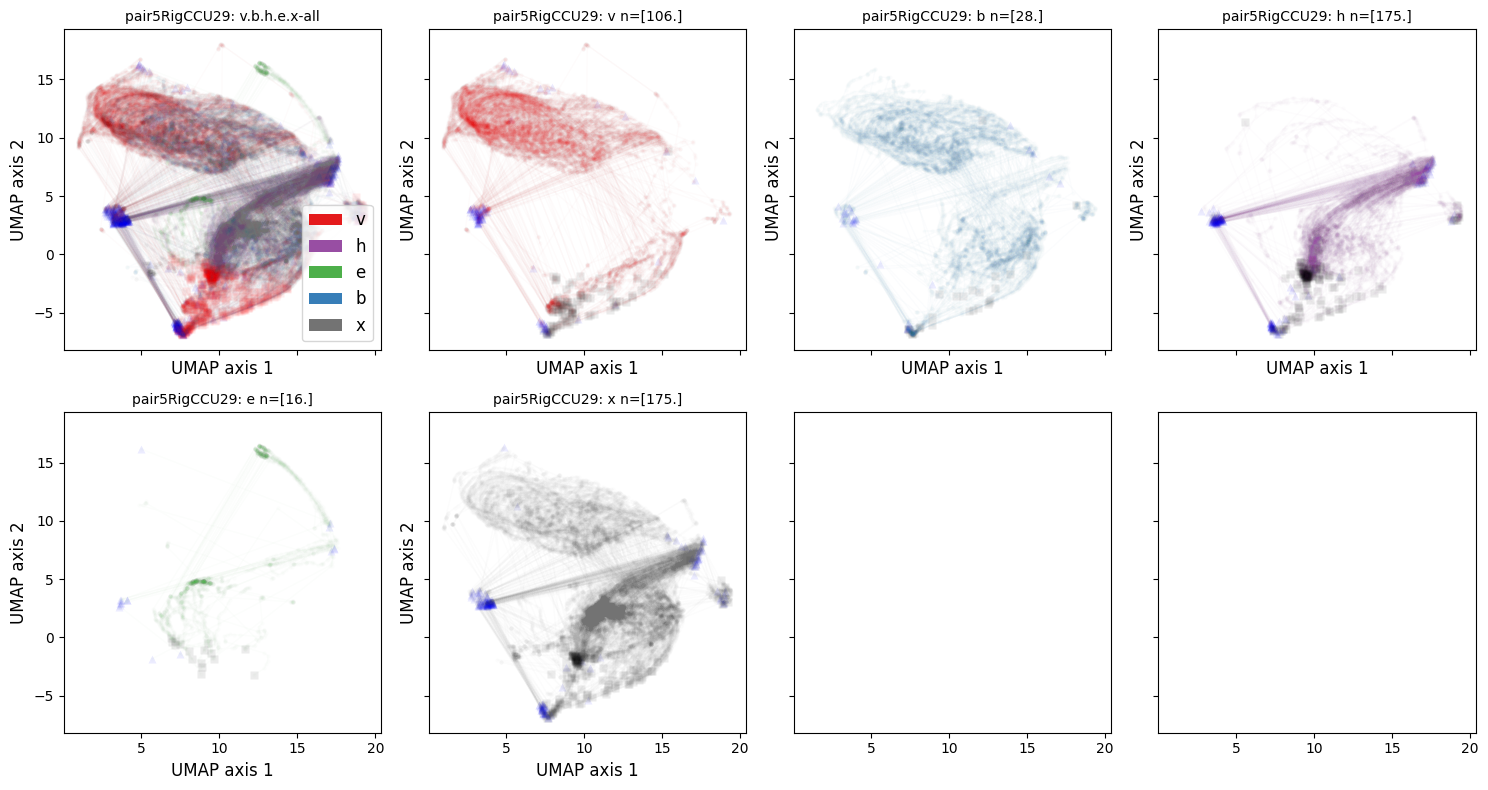

In [53]:
# get the syl id
syl_comb = sorted(list(set(info_umap['syl_ID'])))
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[15, 5.5], sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[15, 8], sharex=True, sharey=True)
syl_counts = np.zeros([len(syl),1])
# for si in range(len(syl_comb)):
for si in range(500):
    ss = syl_comb[si]
    # locate the start and end in the res
    temp = info_umap.loc[info_umap['syl_ID']==ss, :]
    i_start = temp['count_start'].item()
    i_end = temp['count_end'].item()
    x = res[i_start:i_end, 0]
    y = res[i_start:i_end, 1]
    v = temp['label'].item()
    vi = syl.index(v)
    # first  plot in overlaid
    ax = axes[0][0]
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.015, rasterized=True, markeredgecolor='none')
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.075, rasterized=True, markeredgecolor='none')
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.075, rasterized=True, markeredgecolor='none')
    # then plot in separate
    plot_i = (vi+1)//4
    plot_j = (vi+1)%4
    ax = axes[plot_i][plot_j]
    # ax = axes[vi+1]
    syl_counts[vi] += 1
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.015, rasterized=True, markeredgecolor='none')
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.075, rasterized=True, markeredgecolor='none')
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='black', alpha=0.075, rasterized=True, markeredgecolor='none')
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax = axes[0][0]
ax.legend(handles=legends, loc='lower right', fontsize=12)
# add xy axis labels
for plot_i in range(2):
    for plot_j in range(4):
        ax = axes[plot_i][plot_j]
        vi = plot_i*4+plot_j-1
        if vi>=len(syl):
            break
        if plot_i==0 and plot_j==0:
            ax.set_title(f'{birdID}: {umap_run}', fontsize=10)
        else:
            ax.set_title(f'{birdID}: {syl[vi]} n={syl_counts[vi]}', fontsize=10)
        ax.set_xlabel('UMAP axis 1', fontsize=12)
        ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()

#save fig
fn_fig = os.path.join(fd_umap, f'{birdID}.{umap_run}.embedding.pdf')
fig.savefig(fn_fig, dpi=600)